In [1]:
import numpy as np
import theano.tensor as tt

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [130]:
def Observed_Model_using_exp(U,l,alpha,Cx,Cy, factor = None, IMAGE_SIZE_X = 20, IMAGE_SIZE_Y = 20):
    # We have implemented the model defined by:
    # V_obs = sum_{i=0}^{N_BASIS} alpha_i phi_i(u,v)
    # where phi_i(u,v) = exp(-2pi(u^2+v^2)l^2)exp(-j2pi(Cx^i u + Cv^i v))
    
    if factor == None:
        factor = (IMAGE_SIZE_X*IMAGE_SIZE_Y/IMAGE_SIZE_X)
    
    # Rescale u,v space
    u_aux = U[:,0] - IMAGE_SIZE_X/2
    u_aux = u_aux/factor
    v_aux = U[:,1] - IMAGE_SIZE_Y/2
    v_aux = v_aux/factor

    
    # Amplitud (Mantle o carrier)
    A = tt.exp(-2*np.pi**2*(u_aux*u_aux+v_aux*v_aux)*l**2)

    imagExp = tt.exp(-2*np.pi*1j*(Cx[:,np.newaxis]*u_aux + Cy[:,np.newaxis]*v_aux))

    out_real = tt.real(tt.sum(alpha*A*imagExp, axis = 0))
    out_imag = tt.imag(tt.sum(alpha*A*imagExp, axis = 0))
      
    return out_real, out_imag

In [131]:
def Observed_Model_using_sin_cos(U,l,alpha,Cx,Cy, factor = None, IMAGE_SIZE_X = 20, IMAGE_SIZE_Y = 20):
        # We have implemented the model defined by:
    # V_obs = sum_{i=0}^{N_BASIS} alpha_i phi_i(u,v)
    # where phi_i(u,v) = exp(-2pi(u^2+v^2)l^2)exp(-j2pi(Cx^i u + Cv^i v))
    
    if factor == None:
        factor = (IMAGE_SIZE_X*IMAGE_SIZE_Y/IMAGE_SIZE_X)
    
    # Rescale u,v space
    u_aux = U[:,0] - IMAGE_SIZE_X/2
    u_aux = u_aux/factor
    v_aux = U[:,1] - IMAGE_SIZE_Y/2
    v_aux = v_aux/factor
    
    # Amplitud (Mantle o carrier)
    A = tt.exp(-2*np.pi**2*(u_aux*u_aux+v_aux*v_aux)*l**2)

    # Imaginary Exponential (Mudolator)
    cosPart = tt.cos(-2*np.pi*(Cx[:,np.newaxis]*u_aux + Cy[:,np.newaxis]*v_aux))
    sinPart = tt.sin(-2*np.pi*(Cx[:,np.newaxis]*u_aux + Cy[:,np.newaxis]*v_aux))

    ## Finally, alpha_i * phi_i
    out_real = tt.sum(alpha*A*cosPart, axis = 0)
    out_imag = tt.sum(alpha*A*sinPart, axis = 0)

    return out_real, out_imag

In [132]:
size = 1
MAX_VALUE = 255
MIN_VALUE = 0
IMAGE_SIZE_X = 20
IMAGE_SIZE_Y = 20
xCenter = IMAGE_SIZE_X/2
yCenter = IMAGE_SIZE_Y/2
l = 4

#I = np.ceil((MAX_VALUE - MIN_VALUE) * np.random.rand(size) + MIN_VALUE)
#Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(size)).astype('int')
#Cx = np.clip(Cx,0,IMAGE_SIZE_X)
#Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(size)).astype('int')
#Cy = np.clip(Cy,0,IMAGE_SIZE_Y)

I = np.array([180])
Cx = np.array([8])
Cy = np.array([-3])

minI = np.min(I)
argminI = np.argmin(I)
maxI = np.max(I)
argmaxI = np.argmax(I)

print('min I: %s at (%s,%s)\n' \
      'max I: %s at (%s,%s)\n' % (minI, Cx[argminI], Cy[argminI],
                                  maxI, Cx[argmaxI], Cy[argmaxI]))

min I: 180 at (8,-3)
max I: 180 at (8,-3)



In [133]:
# Basis function in pixel domain
def psi(x, y, l, Cx, Cy):
    return (1.0 / (np.sqrt(2.0 * np.pi) * l)) * np.exp(-(1.0 / 2) * ((x - Cx) * (x - Cx) + (y - Cy) * (y - Cy)) / (l * l))

In [134]:
G_SIZE_REAL =  20
x = np.arange((IMAGE_SIZE_X)) - xCenter
y = np.arange((IMAGE_SIZE_Y)) - yCenter
print(x.shape, y.shape)
G = np.zeros([x.shape[0], y.shape[0]])

N_BASIS = I.shape[0]

for i in range(G_SIZE_REAL):
    for j in range(G_SIZE_REAL):
        for k in range(N_BASIS):
            G[i,j] += I[k]*psi(x[j],y[i],l,Cx[k],Cy[k])
        
G_fft = np.fft.fft2(G)
G_fft = np.fft.fftshift(G_fft)

(20,) (20,)


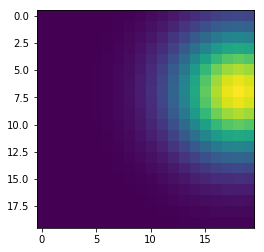

In [135]:
import matplotlib.pyplot as plt

plt.imshow(G)
plt.show()

In [136]:
def matrix_points(U,V_real, V_imag, IMAGE_SIZE_X = 20, IMAGE_SIZE_Y = 20):
#     print(U.shape)
#     print(V_real.shape)
#     print(V_imag.shape)
    U = U.astype(int)
    out_real = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    out_imag = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    for i in range(U.shape[0]):
        out_real[U[i,0],U[i,1]] = V_real[i]
        out_imag[U[i,0],U[i,1]] = V_imag[i]
        
    return out_real, out_imag

In [137]:
V = np.zeros((G_fft.shape[0]*G_fft.shape[1], 2))
U = np.zeros((G_fft.shape[0]*G_fft.shape[1], 2))

for i in range(G_fft.shape[0]):
    for j in range(G_fft.shape[1]):
        index = int(i*IMAGE_SIZE_X+j)
#         print(vIndex)
        V[index, 0] = G_fft.real[i,j]
        V[index, 1] = G_fft.imag[i,j]
#         print('Update: ', index, V[index,:])
        U[index, 0] = x[i] + IMAGE_SIZE_X/2
        U[index, 1] = y[j] + IMAGE_SIZE_Y/2

True
True


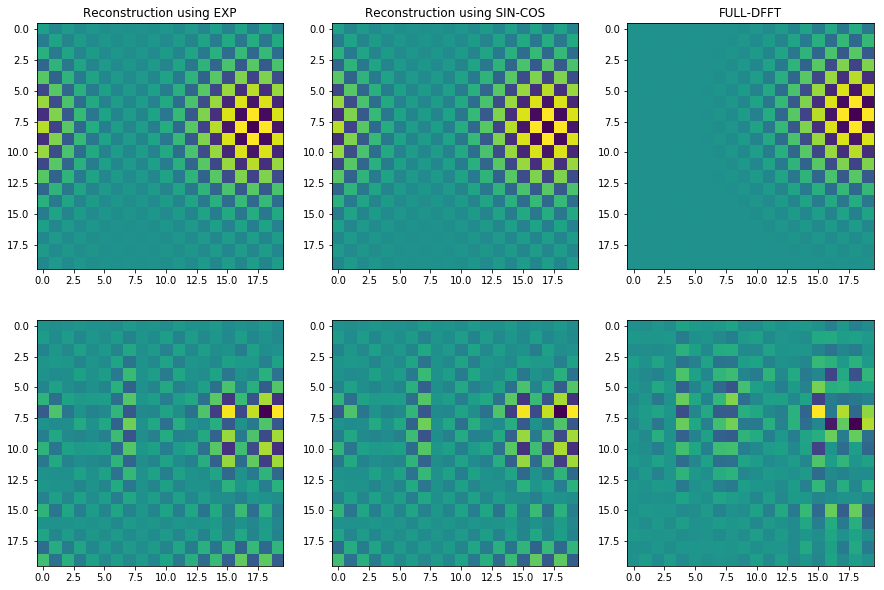

In [148]:
alpha = I*np.sqrt(2*np.pi)*l
PHI_Re, PHI_Im = Observed_Model_using_exp(U,l,alpha,Cx,Cy,
                                          IMAGE_SIZE_X = 20, IMAGE_SIZE_Y= 20,
                                          factor=IMAGE_SIZE_X*IMAGE_SIZE_Y/G_SIZE_REAL)
Im_ind_real, Im_ind_imag = matrix_points(U,PHI_Re.eval(), PHI_Im.eval(),
                                         IMAGE_SIZE_X=G_SIZE_REAL ,IMAGE_SIZE_Y=G_SIZE_REAL)
Im_ind_fft = Im_ind_real + 1j*Im_ind_imag
# print(Im_ind_fft.shape)
Im_ind_exp = np.fft.ifft2(Im_ind_fft)
#Im_ind = np.fft.fftshift(Im_ind)
fig, ax = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(15)
ax[0,0].imshow( Im_ind_exp.real )
ax[0,0].set_title('Reconstruction using EXP')
ax[1,0].imshow( Im_ind_exp.imag )



PHI_Re, PHI_Im = Observed_Model_using_sin_cos(U,l,alpha,Cx,Cy,
                                              IMAGE_SIZE_X = 20, IMAGE_SIZE_Y= 20,
                                              factor=IMAGE_SIZE_X*IMAGE_SIZE_Y/G_SIZE_REAL)

Im_ind_real, Im_ind_imag = matrix_points(U,PHI_Re.eval(), PHI_Im.eval(),
                                         IMAGE_SIZE_X=G_SIZE_REAL ,IMAGE_SIZE_Y=G_SIZE_REAL)
Im_ind_fft = Im_ind_real + 1j*Im_ind_imag
# print(Im_ind_fft.shape)
Im_ind_sin_cos = np.fft.ifft2(Im_ind_fft)
#Im_ind = np.fft.fftshift(Im_ind)
ax[0,1].imshow( Im_ind_sin_cos.real )
ax[0,1].set_title('Reconstruction using SIN-COS')
ax[1,1].imshow( Im_ind_sin_cos.imag )

print(np.array_equal(Im_ind_exp.real, Im_ind_sin_cos.real))
print(np.array_equal(Im_ind_exp.imag, Im_ind_sin_cos.imag))

G_fft_ifft = np.fft.ifft2(G_fft)
ax[0,2].imshow(G_fft_ifft.real)
ax[0,2].set_title('FULL-DFFT')
ax[1,2].imshow(G_fft_ifft.imag)
plt.show()

plt.show()